In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# 设置随机种子以便结果可复现
np.random.seed(42)

# 生成模拟数据
N = 10000  # 样本总数
P = 3     # 协变量的数量
X = np.random.randn(N, P)  # 生成协变量
beta_true = np.array([3, -1, 2])  # 真实的模型参数
epsilon = np.random.normal(0, 1, N)  # 生成误差项
Y = X @ beta_true + epsilon  # 生成响应变量

# 将数据转换为DataFrame格式
data = pd.DataFrame(data=np.column_stack((Y, X)), columns=['Y'] + [f'X{i+1}' for i in range(P)])


In [2]:
# 定义分层抽样函数
def stratified_sampling(data, n):
    data['stratum'] = pd.qcut(data['X1'], 5)  # 将第一个协变量分成5个分层
    sampled_data = data.groupby('stratum', group_keys=False).apply(lambda x: x.sample(min(len(x), n)))
    return sampled_data.drop(columns='stratum')

# 定义简单随机抽样函数
def simple_random_sampling(data, n):
    return data.sample(n)

# 设定抽样样本数量
n = 50

# 进行简单随机抽样
sampled_data_simple_random = simple_random_sampling(data, n)

# 进行分层抽样
sampled_data_stratified = stratified_sampling(data, n)


C:\Users\29550\AppData\Local\Temp\ipykernel_26000\26120877.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sampled_data = data.groupby('stratum', group_keys=False).apply(lambda x: x.sample(min(len(x), n)))
C:\Users\29550\AppData\Local\Temp\ipykernel_26000\26120877.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_data = data.groupby('stratum', group_keys=False).apply(lambda x: x.sample(min(len(x), n)))


In [3]:
# 从抽样数据中提取X和Y
X_simple_random = sampled_data_simple_random.drop(columns='Y').values
Y_simple_random = sampled_data_simple_random['Y'].values
X_stratified = sampled_data_stratified.drop(columns='Y').values
Y_stratified = sampled_data_stratified['Y'].values

# 定义函数来估计线性模型参数并返回模型参数估计值
def estimate_parameters(X, Y):
    model = LinearRegression()
    model.fit(X, Y)
    return model.coef_

# 估计模型参数
parameters_true = beta_true
parameters_simple_random = estimate_parameters(X_simple_random, Y_simple_random)
parameters_stratified = estimate_parameters(X_stratified, Y_stratified)

# 打印真实参数和估计参数
print("True Parameters:", parameters_true)
print("Parameters Estimated by Simple Random Sampling:", parameters_simple_random)
print("Parameters Estimated by Stratified Sampling:", parameters_stratified)


True Parameters: [ 3 -1  2]
Parameters Estimated by Simple Random Sampling: [ 3.06207177 -1.12032021  2.00343604]
Parameters Estimated by Stratified Sampling: [ 2.96441971 -0.87830528  2.06529386]


In [4]:
# 定义函数来评估模型参数估计的准确性（使用均方误差）
def evaluate_performance(parameters_true, parameters_estimated):
    return mean_squared_error(parameters_true, parameters_estimated)

# 评估两种抽样方法的性能
mse_simple_random = evaluate_performance(parameters_true, parameters_simple_random)
mse_stratified = evaluate_performance(parameters_true, parameters_stratified)

# 打印均方误差
print("Mean Squared Error (Simple Random Sampling):", mse_simple_random)
print("Mean Squared Error (Stratified Sampling):", mse_stratified)


Mean Squared Error (Simple Random Sampling): 0.006113887906124274
Mean Squared Error (Stratified Sampling): 0.006779616779388597


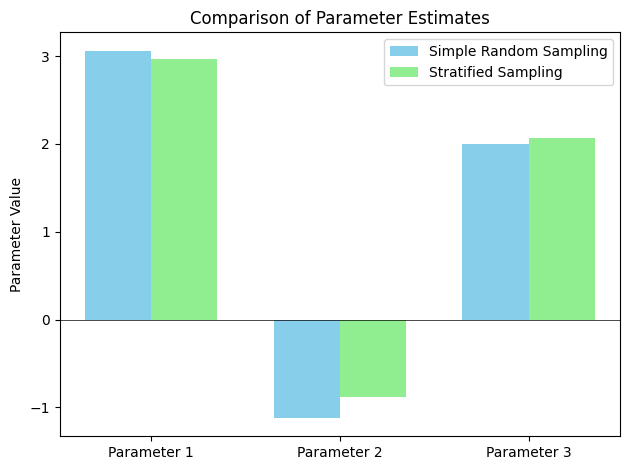

In [5]:
# 可视化比较结果
labels = [f'Parameter {i+1}' for i in range(len(parameters_true))]
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, parameters_simple_random, width, label='Simple Random Sampling', color='skyblue')
rects2 = ax.bar(x + width/2, parameters_stratified, width, label='Stratified Sampling', color='lightgreen')
ax.axhline(y=0, color='black', linewidth=0.5)  # 添加水平线以显示真实参数值
ax.set_ylabel('Parameter Value')
ax.set_title('Comparison of Parameter Estimates')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()


plt.show()


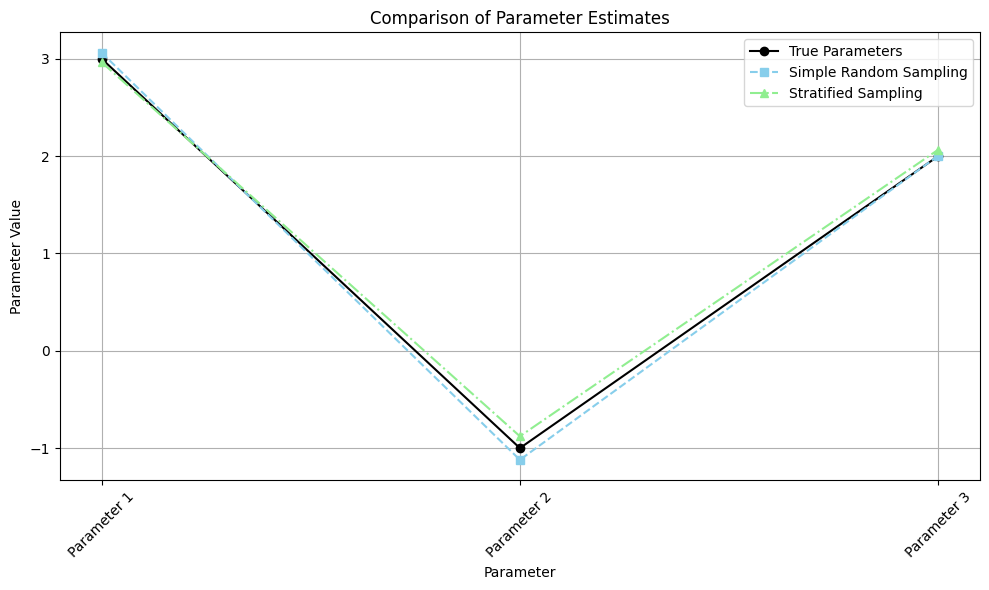

In [6]:
# 可视化比较结果并保存为图片
plt.figure(figsize=(10, 6))

plt.plot(labels, parameters_true, marker='o', linestyle='-', label='True Parameters', color='black')
plt.plot(labels, parameters_simple_random, marker='s', linestyle='--', label='Simple Random Sampling', color='skyblue')
plt.plot(labels, parameters_stratified, marker='^', linestyle='-.', label='Stratified Sampling', color='lightgreen')

plt.xlabel('Parameter')
plt.ylabel('Parameter Value')
plt.title('Comparison of Parameter Estimates')
plt.xticks(rotation=45)
plt.legend()

plt.grid(True)
plt.tight_layout()


plt.show()


In [7]:
# 生成模拟数据（分类变量）
Y_classification = np.random.choice([0, 1], size=N, p=[0.5, 0.5])  # 以相等的概率生成0和1的分类变量

# 将数据转换为DataFrame格式
data_classification = pd.DataFrame(data=np.column_stack((Y_classification, X)), columns=['Y', 'X1', 'X2', 'X3'])

# 定义函数来进行过采样或欠采样
def balance_classes(data):
    count_class_0 = (data['Y'] == 0).sum()
    count_class_1 = (data['Y'] == 1).sum()
    data_class_0 = data[data['Y'] == 0]
    data_class_1 = data[data['Y'] == 1]
    
    if count_class_0 > count_class_1:
        data_class_0 = data_class_0.sample(count_class_1, replace=False)
        balanced_data = pd.concat([data_class_0, data_class_1], axis=0)
    elif count_class_1 > count_class_0:
        data_class_1 = data_class_1.sample(count_class_0, replace=False)
        balanced_data = pd.concat([data_class_0, data_class_1], axis=0)
    else:
        balanced_data = data.copy()
    
    return balanced_data


def evaluate_accuracy(X, y_true, model):
    """
    计算模型的准确性
    :param X: 输入特征数据
    :param y_true: 真实的类别标签
    :param model: 已训练的模型
    :return: 准确性
    """
    y_pred = model.predict(X)
    accuracy = np.mean(y_pred == y_true)
    return accuracy

from sklearn.linear_model import LogisticRegression

def train_logistic_regression(X, y):
    """
    训练逻辑回归模型
    :param X: 输入特征数据
    :param y: 类别标签
    :return: 训练得到的模型参数
    """
    model = LogisticRegression()
    model.fit(X, y)
    return model.coef_[0]



In [8]:
# 检查 Y_balanced_stratified 的唯一值和类型
#unique_values_stratified = np.unique(Y_balanced_stratified)
#print("Unique Values in Y_balanced_stratified:", unique_values_stratified)
#print("Data Type of Y_balanced_stratified:", type(Y_balanced_stratified))

# 检查 Y_balanced_simple_random 的唯一值和类型
#unique_values_simple_random = np.unique(Y_balanced_simple_random)
#print("Unique Values in Y_balanced_simple_random:", unique_values_simple_random)
#print("Data Type of Y_balanced_simple_random:", type(Y_balanced_simple_random))


# 过采样或欠采样，以平衡类别
balanced_data_stratified = balance_classes(sampled_data_stratified)
balanced_data_simple_random = balance_classes(sampled_data_simple_random)

# 从平衡后的抽样数据中提取X和Y
X_balanced_stratified = balanced_data_stratified.drop(columns='Y').values
Y_balanced_stratified = balanced_data_stratified['Y'].values
X_balanced_simple_random = balanced_data_simple_random.drop(columns='Y').values
Y_balanced_simple_random = balanced_data_simple_random['Y'].values




# 转换连续的数值标签为二元类别标签
Y_balanced_stratified_binary = np.where(Y_balanced_stratified >= 0, 1, 0)
Y_balanced_simple_random_binary = np.where(Y_balanced_simple_random >= 0, 1, 0)

# 训练逻辑回归模型
parameters_logistic_regression_stratified = train_logistic_regression(X_balanced_stratified, Y_balanced_stratified_binary)
parameters_logistic_regression_simple_random = train_logistic_regression(X_balanced_simple_random, Y_balanced_simple_random_binary)

# 打印逻辑回归模型参数
print("Parameters Estimated by Logistic Regression (Stratified Sampling):", parameters_logistic_regression_stratified)
print("Parameters Estimated by Logistic Regression (Simple Random Sampling):", parameters_logistic_regression_simple_random)

# 评估逻辑回归模型的准确性
accuracy_stratified = evaluate_accuracy(X_balanced_stratified, Y_balanced_stratified_binary, LogisticRegression().fit(X_balanced_stratified, Y_balanced_stratified_binary))
accuracy_simple_random = evaluate_accuracy(X_balanced_simple_random, Y_balanced_simple_random_binary, LogisticRegression().fit(X_balanced_simple_random, Y_balanced_simple_random_binary))

# 打印模型准确性
print("Accuracy (Stratified Sampling):", accuracy_stratified)
print("Accuracy (Simple Random Sampling):", accuracy_simple_random)


Parameters Estimated by Logistic Regression (Stratified Sampling): [ 3.47253287 -1.24080198  2.60142314]
Parameters Estimated by Logistic Regression (Simple Random Sampling): [ 2.1375966  -0.73843819  1.52789854]
Accuracy (Stratified Sampling): 0.916
Accuracy (Simple Random Sampling): 0.94


In [9]:
from imblearn.over_sampling import SMOTE

# 实例化SMOTE对象
smote = SMOTE()

# 对X_balanced_stratified进行过采样
X_balanced_stratified_smote, Y_balanced_stratified_smote = smote.fit_resample(X_balanced_stratified, Y_balanced_stratified_binary)

# 训练逻辑回归模型
parameters_logistic_regression_stratified_smote = train_logistic_regression(X_balanced_stratified_smote, Y_balanced_stratified_smote)

# 评估逻辑回归模型的准确性
accuracy_stratified_smote = evaluate_accuracy(X_balanced_stratified_smote, Y_balanced_stratified_smote, LogisticRegression().fit(X_balanced_stratified_smote, Y_balanced_stratified_smote))

# 打印模型准确性
print("Parameters Estimated by Logistic Regression (Stratified Sampling with SMOTE):", parameters_logistic_regression_stratified_smote)
print("Accuracy (Stratified Sampling with SMOTE):", accuracy_stratified_smote)


Parameters Estimated by Logistic Regression (Stratified Sampling with SMOTE): [ 3.49578119 -1.25491724  2.60522424]
Accuracy (Stratified Sampling with SMOTE): 0.9166666666666666


In [49]:
from sklearn.ensemble import RandomForestClassifier

# 训练随机森林分类器
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_balanced_stratified, Y_balanced_stratified_binary)

# 评估模型准确性
accuracy_rf = evaluate_accuracy(X_balanced_stratified, Y_balanced_stratified_binary, rf_classifier)

# 打印模型准确性
print("Accuracy (Random Forest Classifier):", accuracy_rf)


Accuracy (Random Forest Classifier): 1.0


In [13]:
from sklearn.ensemble import RandomForestClassifier

# 实例化随机森林分类器
random_forest = RandomForestClassifier()

# 使用平衡后的数据进行训练
random_forest.fit(X_balanced_stratified, Y_balanced_stratified_binary)

# 评估随机森林分类器的准确性
accuracy_random_forest = evaluate_accuracy(X_balanced_stratified, Y_balanced_stratified_binary, random_forest)

# 打印模型准确性
print("Accuracy (Random Forest Classifier):", accuracy_random_forest)


Accuracy (Random Forest Classifier): 1.0


In [14]:
from sklearn.model_selection import cross_val_score

# 使用交叉验证评估随机森林分类器的性能
scores = cross_val_score(random_forest, X_balanced_stratified, Y_balanced_stratified_binary, cv=5)

# 打印交叉验证的准确率
print("Cross-Validation Accuracy (Random Forest Classifier):", scores.mean())


Cross-Validation Accuracy (Random Forest Classifier): 0.704


In [15]:
from imblearn.over_sampling import KMeansSMOTE

# 实例化KMeansSMOTE对象
kmeans_smote = KMeansSMOTE()

# 对X_balanced_stratified进行过采样
X_balanced_stratified_kmeans_smote, Y_balanced_stratified_kmeans_smote = kmeans_smote.fit_resample(X_balanced_stratified, Y_balanced_stratified_binary)

# 训练逻辑回归模型
parameters_logistic_regression_stratified_kmeans_smote = train_logistic_regression(X_balanced_stratified_kmeans_smote, Y_balanced_stratified_kmeans_smote)

# 评估逻辑回归模型的准确性
accuracy_stratified_kmeans_smote = evaluate_accuracy(X_balanced_stratified_kmeans_smote, Y_balanced_stratified_kmeans_smote, LogisticRegression().fit(X_balanced_stratified_kmeans_smote, Y_balanced_stratified_kmeans_smote))

# 打印模型准确性
print("Parameters Estimated by Logistic Regression (Stratified Sampling with K-Means SMOTE):", parameters_logistic_regression_stratified_kmeans_smote)
print("Accuracy (Stratified Sampling with K-Means SMOTE):", accuracy_stratified_kmeans_smote)


Parameters Estimated by Logistic Regression (Stratified Sampling with K-Means SMOTE): [ 3.50980686 -1.23660299  2.62112672]
Accuracy (Stratified Sampling with K-Means SMOTE): 0.9173228346456693


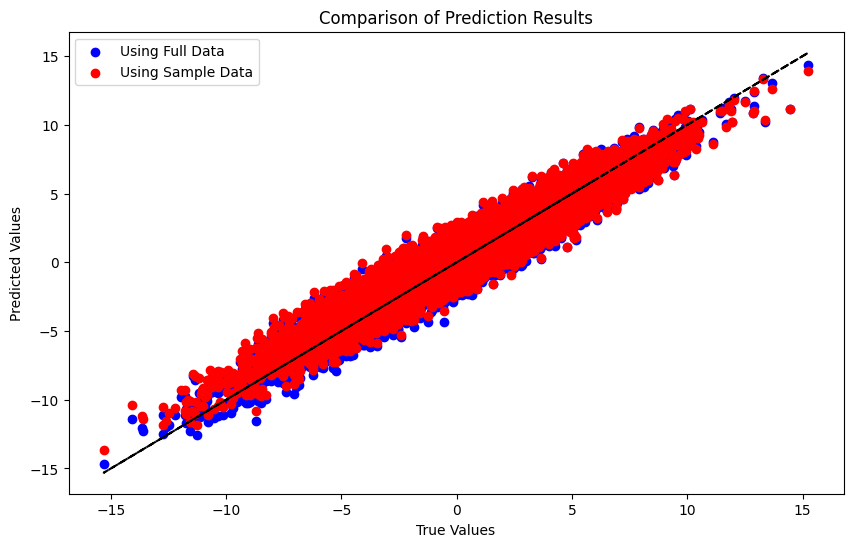

MSE using Full Data: 1.0170704342239563
MSE using Sample Data: 1.1220117472402353


In [31]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# 生成模拟数据
np.random.seed(0)
N = 10000  # 总样本数量
n = 100  # 观测到的样本数量
p = 3  # 特征数量
X = np.random.randn(N, p)  # 特征变量
beta = np.array([1, 2, 3])  # 真实的参数值
epsilon = np.random.normal(0, 1, N)  # 随机误差项
Y = np.dot(X, beta) + epsilon  # 响应变量

# 随机抽取 n 个观测样本
sample_indices = np.random.choice(N, n, replace=False)
X_sample = X[sample_indices]
Y_sample = Y[sample_indices]

# 使用全部数据拟合线性回归模型
lr = LinearRegression()
lr.fit(X, Y)
Y_pred_full = lr.predict(X)

# 使用观测到的样本拟合线性回归模型
lr_sample = LinearRegression()
lr_sample.fit(X_sample, Y_sample)
Y_pred_sample = lr_sample.predict(X)

# 计算两种方法的均方误差
mse_full = mean_squared_error(Y, Y_pred_full)
mse_sample = mean_squared_error(Y, Y_pred_sample)

# 可视化预测结果
plt.figure(figsize=(10, 6))
plt.scatter(Y, Y_pred_full, color='blue', label='Using Full Data')
plt.scatter(Y, Y_pred_sample, color='red', label='Using Sample Data')
plt.plot(Y, Y, color='black', linestyle='--')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Comparison of Prediction Results')
plt.legend()
plt.show()

# 打印均方误差
print("MSE using Full Data:", mse_full)
print("MSE using Sample Data:", mse_sample)


In [38]:
from sklearn.metrics import mean_absolute_error, r2_score

# 计算平均绝对误差（MAE）
mae_full = mean_absolute_error(Y, Y_pred_full)
mae_sample = mean_absolute_error(Y, Y_pred_sample)

# 计算解释方差分（R^2）
r2_full = r2_score(Y, Y_pred_full)
r2_sample = r2_score(Y, Y_pred_sample)

# 计算均方根误差（RMSE）
rmse_full = np.sqrt(mse_full)
rmse_sample = np.sqrt(mse_sample)

# 输出其他指标
print("MAE using Full Data:", mae_full)
print("MAE using Sample Data:", mae_sample)
print("R^2 using Full Data:", r2_full)
print("R^2 using Sample Data:", r2_sample)
print("RMSE using Full Data:", rmse_full)
print("RMSE using Sample Data:", rmse_sample)


MAE using Full Data: 0.799723111077382
MAE using Sample Data: 0.8374258051977893
R^2 using Full Data: 0.9312963039127612
R^2 using Sample Data: 0.9242074575223266
RMSE using Full Data: 1.0084990997635825
RMSE using Sample Data: 1.0592505592352714


In [ ]:
# 创建一个横向排列的复合图
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# 设置颜色和样式
colors = ['skyblue', 'salmon']
bar_width = 0.4

# 绘制平均绝对误差（MAE）比较图
axs[0].bar(['Full Data', 'Sample Data'], [mae_full, mae_sample], color=colors)
axs[0].set_title('Comparison of Mean Absolute Error (MAE)', fontsize=14)
axs[0].set_ylabel('MAE', fontsize=12)
axs[0].grid(True)

# 绘制解释方差分（R^2）比较图
axs[1].bar(['Full Data', 'Sample Data'], [r2_full, r2_sample], color=colors)
axs[1].set_title('Comparison of R^2 Score', fontsize=14)
axs[1].set_ylabel('R^2 Score', fontsize=12)
axs[1].grid(True)

# 绘制均方根误差（RMSE）比较图
axs[2].bar(['Full Data', 'Sample Data'], [rmse_full, rmse_sample], color=colors)
axs[2].set_title('Comparison of Root Mean Squared Error (RMSE)', fontsize=14)
axs[2].set_ylabel('RMSE', fontsize=12)
axs[2].grid(True)

# 调整子图之间的间距
plt.tight_layout()

# 显示图形
plt.show()
